# Previsão de séries temporais utilizando redes recorrentes (RNNs) e/ou long short-term memory (LSTM)

In [1]:
""" Importando as bibliotecas necessárias """

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.linalg import toeplitz as toeplitz


In [2]:
""" Rotina que prepara uma matriz com K valores passados (time-steps) para cada instante (só com valores válidos da série)
    e o vetor com as saídas desejadas (no caso, o valor da série temporal L passos à frente)
"""

def pre_process(data,max_K,L):
    
    #primeira linha
    lin = data[0,max_K-1:N-L]
    #primeira coluna
    col = data[0,0:max_K]
    #reverte a ordem, para deixar o vetor na forma [data[K-1]  ... data[0]]^T
    col = col[::-1]
    #matriz com as max_K amostras passadas para a previsão L passos à frente    
    X = toeplitz(col,lin)
    #matriz com a resposta desejada (valor da série temporal L passos à frente)
    y = data[0,L+max_K-1:N]
    
    return X.T,y.T

In [6]:
""" Carregando os dados e preparando os conjuntos de treinamento, validação e teste """

#carregando os dados de temperatura
series = pd.read_csv('daily-minimum-temperatures.csv')

#sequência de valores diários de temperatura (01/01/1981 a 31/12/1990)
data = series.values[:,1]
data = np.array(data, dtype=np.float)

#número total de amostras
N = data.size
#vetorizando o conjunto de dados
data = data.reshape((1,N))

#passo de predição
L = 1
#número de time_steps utilizados (pensando no treinamento e na evolução da LSTM)
num_steps = 5

#constrói a matriz completa dos dados
[X,y] = pre_process(data,num_steps,L)

#dimensões da matriz completa de dados de entrada
(n_padroes,n_ent) = X.shape

""" Separação dos dados em conjunto de treinamento e teste """

#número de amostras presentes no conjunto de teste: últimas 365 amostras (1990)
num_teste = 365;

#dados de teste
Xteste = X[-num_teste:,:]
yteste = y[-num_teste:]
#dimensões da matriz completa de dados de teste
(n_padroes_teste,n_ent) = Xteste.shape

#dados de treinamento + validação
Xtemp = X[0:n_padroes-num_teste,:]
ytemp = y[0:n_padroes-num_teste]

#separação em treinamento e validação
Xtr,Xval,ytr,yval = train_test_split(Xtemp,ytemp,test_size=0.25,shuffle=False)

#captura as dimensões originais das matrizes de dados
np_tr,nsteps = Xtr.shape
np_val = Xval.shape[0]
np_teste = Xteste.shape[0]


## Abordagens:

### Many-to-one com entrada escalar
* (batch_size,n_steps,1): Neste caso, cada "padrão" possui n_steps instantes de tempo; isso significa que o BPTT considera este número de cópias da estrutura da rede para calcular a saída, o erro e as derivadas. Além disso, isso também quer dizer que a entrada em cada instante de tempo é um valor único (escalar); finalmente, a camada LSTM retorna somente o valor da saída para o último instante de tempo (que é a previsão de um passo à frente).

### One-to-one com entrada vetorial
* (batch_size,1,n_steps): cada "padrão" consiste de um único instante temporal (portanto, o BPTT considera apenas 1 cópia da estrutura da rede) e processa os atrasos como se fossem as features do vetor de entrada. Logo, a entrada da rede é um vetor com alguns lags (a saber, n_steps atrasos) atuando como features. A saída continua sendo um valor único, o qual é obtido combinando as informações dos neurônios, os quais receberam as cinco features e possuem realimentação do instante anterior.

### Many-to-many
* Para termos esta configuração, é preciso ativar a opção return_sequences de todas as camadas recorrentes; assim, a camada densa receberá (dentro da opção TimeDistributed) as saídas da camada recorrente para cada instante de tempo de entrada. O número de neurônios na camada densa define se estamos estimando um único valor (um passo à frente) ou diretamente múltiplos passos à frente (daí, teremos um vetor como saída). É possível, também, ter many-to-many com entrada vetorial (em que os atrasos são considerados como features). 

In [7]:
""" Preparação final dos dados e da rede para o treinamento  """

""" Abordagem mais intuitiva: cada "padrão" possui nsteps instantes de tempo; isso significa que o BPTT 
considera este número de cópias da estrutura da rede para calcular a saída, o erro e as derivadas. Além disso, 
isso também quer dizer que a entrada em cada instante é um valor único (escalar). """

Xtr = np.reshape(Xtr,(np_tr,nsteps,1))
Xval = np.reshape(Xval,(np_val,nsteps,1))
Xteste = np.reshape(Xteste,(np_teste,nsteps,1))

""" Forma alternativa: cada "padrão" consiste de um único instante temporal (portanto, o BPTT considera 
apenas 1 cópia da estrutura da rede) e processa os atrasos como se fossem as features do vetor de entrada. 
Logo, a entrada da rede é um vetor com nsteps. A saída continua sendo um valor único, o qual é obtido 
combinando as informações dos neurônios, os quais receberam as cinco features e possuem realimentação do 
instante anterior. """

#Xtr = np.reshape(Xtr,(np_tr,1,nsteps))
#Xval = np.reshape(Xval,(np_val,1,nsteps))
#Xteste = np.reshape(Xteste,(np_teste,1,nsteps))

# MODELO DE REDE UTILIZADO 

#camada de entrada: a dimensão deve ser compatível com o tipo de formatação escolhida para os dados
inputs = keras.Input(shape=(nsteps,1))
layer1 = keras.layers.SimpleRNN(10,activation='relu')(inputs)
#layer1 = keras.layers.SimpleRNN(10,activation='relu',return_sequences=True)(inputs)
#layer2 = keras.layers.SimpleRNN(40,activation='relu')(layer1)
outputs = keras.layers.Dense(1)(layer1)
model = keras.Model(inputs=inputs, outputs=outputs)

#seta o parâmetro para cálculo do MAPE
keras.backend.set_epsilon(1)

#compilação do modelo
model.compile(loss= 'mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])

model.summary()

#realiza o treinamento do modelo
history = model.fit(Xtr,ytr,batch_size=32,epochs=200,verbose=1,validation_data=(Xval,yval))


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Train on 2445 samples, validate on 815 samples
Epoch 1/200
2445/2445 [==============================] - 1s 531us/sample - loss: 29.9629 - root_mean_squared_error: 5.4738 - mean_absolute_percentage_error: 43.0602 - val_loss: 10.4345 - val_root_mean_squared_error: 3.2302 - val_mean_absolute_percentage_error: 27.7540
Epoch 2/200
2445/2445 [==============================] - 0s 189us/sample - 

365/365 [==============================] - 0s 65us/sample - loss: 5.1636 - root_mean_squared_error: 2.2723 - mean_absolute_percentage_error: 18.8270


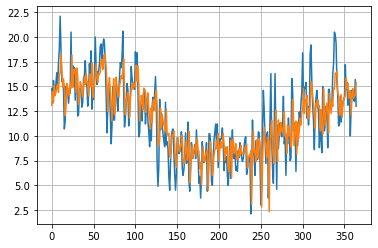

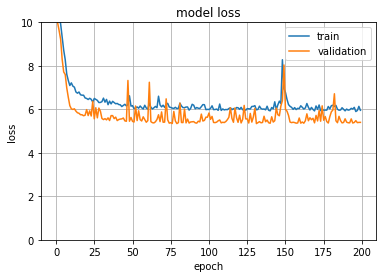

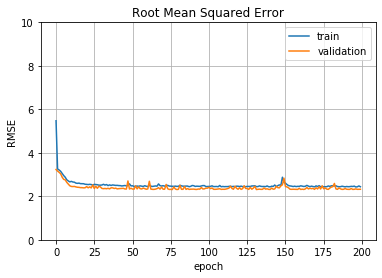

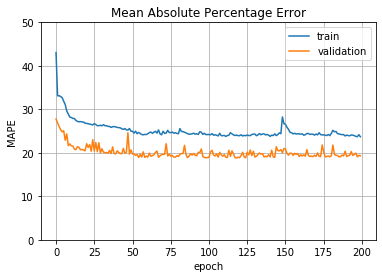

In [10]:
""" Avaliação do desempenho """

#aplicação do modelo ao conjunto de teste
y_estim = model.predict(Xteste,batch_size=32)

#obtém o erro quadrático médio de teste
results = model.evaluate(Xteste, yteste)

plt.figure()
plt.plot(yteste)
plt.plot(y_estim)
plt.grid(True)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid(True)
plt.ylim((0,10))
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid(True)
plt.ylim((0,10))
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Mean Absolute Percentage Error')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid(True)
plt.ylim((0,50))
plt.show()